## Composite over eddies (e.g. Agulhas rings)

1) Remap data onto MR25 grid \
	\>> sbatch remap_mm_r2b8O_MR25.job zos ngc2013

2) Split files into yyyymm \
	Edit  split_mm_yrmth.sh \
	varname=zos \
	varname=Wind_Speed_10m \
	varname=atmos_fluxes_HeatFlux_Latent \
	varname=mlotst \
	varname=sea_level_pressure \
	varname=to \
	expid=ngc2013 \
	expid=rthk001 \
	\>> ./split_mm_yrmth.sh

3) eddy identification to get anticyclones and cyclones (only with zos) \
	Notebook with some figures to show identified eddies [eddy-identification.ipynb] \
	#Submit scripts for each year using submit\_IDeddy\_mm.job, which in turn submits IDeddy\_mm.py script for each month \
	\>> for yr in \\$\(seq 2020 2049\)\; do sbatch submit\_IDeddy\_mm.job \\${yr}\; done

4) high pass filter other fields \
	\>> sbatch remap_mm_r2b8O_MR25.job Wind_Speed_10m ngc2013 \
	\>> sbatch remap_mm_r2b8O_MR25.job atmos_fluxes_HeatFlux_Latent ngc2013 \
	\>> sbatch remap_mm_r2b8O_MR25.job mlotst ngc2013 \
	\>> sbatch remap_mm_r2b8O_MR25.job sea_level_pressure ngc2013 \
	\>> sbatch remap_mm_r2b8O_MR25.job to ngc2013 

5) composite for a given region (Agulhas rings) \
    monthly-eddy-composites.ipynb

Grab Agulhas rings for YYYY=2020
Skip mth=1
Grab Agulhas rings for YYYY=2021
Grab Agulhas rings for YYYY=2022
Grab Agulhas rings for YYYY=2023
Grab Agulhas rings for YYYY=2024
Grab Agulhas rings for YYYY=2025
Grab Agulhas rings for YYYY=2026
Grab Agulhas rings for YYYY=2027
Grab Agulhas rings for YYYY=2028
Grab Agulhas rings for YYYY=2029
Grab Agulhas rings for YYYY=2030
Grab Agulhas rings for YYYY=2031
Grab Agulhas rings for YYYY=2032
Grab Agulhas rings for YYYY=2033
Grab Agulhas rings for YYYY=2034
Grab Agulhas rings for YYYY=2035
Grab Agulhas rings for YYYY=2036
Grab Agulhas rings for YYYY=2037
Grab Agulhas rings for YYYY=2038
Grab Agulhas rings for YYYY=2039
Grab Agulhas rings for YYYY=2040
Grab Agulhas rings for YYYY=2041
Grab Agulhas rings for YYYY=2042
Grab Agulhas rings for YYYY=2043
Grab Agulhas rings for YYYY=2044
Grab Agulhas rings for YYYY=2045
Grab Agulhas rings for YYYY=2046
Grab Agulhas rings for YYYY=2047
Grab Agulhas rings for YYYY=2048
Grab Agulhas rings for YYYY=2049

<a list of 3 text.Text objects>

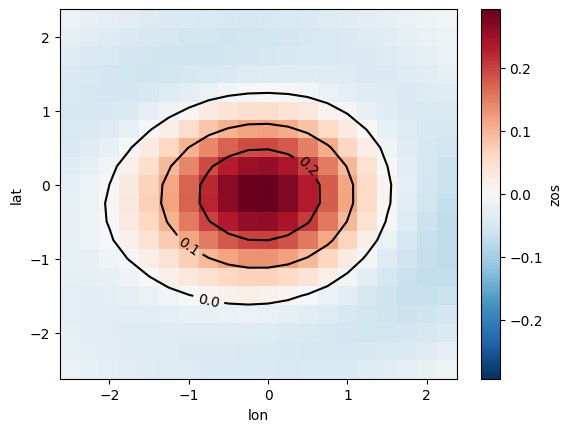

In [3]:
#Get Agulhas rings and composite

from matplotlib import pyplot as plt
from matplotlib.path import Path
from numpy import ones
from datetime import datetime
import numpy as np
import warnings
import xarray as xr

from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset, GridDataset
from py_eddy_tracker.observations.observation import EddiesObservations
from py_eddy_tracker.poly import create_vertice


expid='ngc2013'
varname='zos'
fq='mm'
outdir='/work/mh0287/m300466/topaz/'+expid+'/'
wavelength = 700  #choice of spatial cutoff for high pass filter in km

dlon=2.5
dlat=2.5

SSHcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+varname+'/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+varname+'/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            dssh=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            SSH=dssh[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                SSHcomp.append(SSH.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dssh)
            del(SSH)
            del(ARidx)
            del(a)
            # del(c)
            del(date)

        
res=0.25
npts=int(dlon/res) #number of points from centre
for ii in range(len(SSHcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    SSHcomp[ii]=SSHcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)

Grab Agulhas rings Wind_Speed_10m for YYYY=2020
Skip mth=1
Grab Agulhas rings Wind_Speed_10m for YYYY=2021
Grab Agulhas rings Wind_Speed_10m for YYYY=2022
Grab Agulhas rings Wind_Speed_10m for YYYY=2023
Grab Agulhas rings Wind_Speed_10m for YYYY=2024
Grab Agulhas rings Wind_Speed_10m for YYYY=2025
Grab Agulhas rings Wind_Speed_10m for YYYY=2026
Grab Agulhas rings Wind_Speed_10m for YYYY=2027
Grab Agulhas rings Wind_Speed_10m for YYYY=2028
Grab Agulhas rings Wind_Speed_10m for YYYY=2029
Grab Agulhas rings Wind_Speed_10m for YYYY=2030
Grab Agulhas rings Wind_Speed_10m for YYYY=2031
Grab Agulhas rings Wind_Speed_10m for YYYY=2032
Grab Agulhas rings Wind_Speed_10m for YYYY=2033
Grab Agulhas rings Wind_Speed_10m for YYYY=2034
Grab Agulhas rings Wind_Speed_10m for YYYY=2035
Grab Agulhas rings Wind_Speed_10m for YYYY=2036
Grab Agulhas rings Wind_Speed_10m for YYYY=2037
Grab Agulhas rings Wind_Speed_10m for YYYY=2038
Grab Agulhas rings Wind_Speed_10m for YYYY=2039
Grab Agulhas rings Wind_Speed

<a list of 3 text.Text objects>

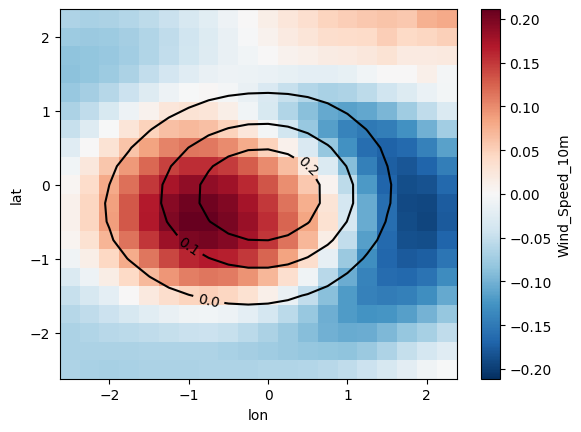

In [10]:
varname='Wind_Speed_10m'
FIELDcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings '+varname+' for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            FIELD=dsvar[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                FIELDcomp.append(FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dsvar)
            del(FIELD)
            del(ARidx)
            del(a)
            # del(c)
            del(date)
            
        
# res=0.25
# npts=int(dlon/res) #number of points from centre
for ii in range(len(FIELDcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


# xr.concat(WSPDcomp,dim='eddy').mean(dim='eddy')
fig, ax = plt.subplots()
xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)          
            

Grab Agulhas rings atmos_fluxes_HeatFlux_Latent for YYYY=2020
Skip mth=1
Grab Agulhas rings atmos_fluxes_HeatFlux_Latent for YYYY=2021
Grab Agulhas rings atmos_fluxes_HeatFlux_Latent for YYYY=2022
Grab Agulhas rings atmos_fluxes_HeatFlux_Latent for YYYY=2023
Grab Agulhas rings atmos_fluxes_HeatFlux_Latent for YYYY=2024
Grab Agulhas rings atmos_fluxes_HeatFlux_Latent for YYYY=2025
Grab Agulhas rings atmos_fluxes_HeatFlux_Latent for YYYY=2026
Grab Agulhas rings atmos_fluxes_HeatFlux_Latent for YYYY=2027
Grab Agulhas rings atmos_fluxes_HeatFlux_Latent for YYYY=2028
Grab Agulhas rings atmos_fluxes_HeatFlux_Latent for YYYY=2029
Grab Agulhas rings atmos_fluxes_HeatFlux_Latent for YYYY=2030
Grab Agulhas rings atmos_fluxes_HeatFlux_Latent for YYYY=2031
Grab Agulhas rings atmos_fluxes_HeatFlux_Latent for YYYY=2032
Grab Agulhas rings atmos_fluxes_HeatFlux_Latent for YYYY=2033
Grab Agulhas rings atmos_fluxes_HeatFlux_Latent for YYYY=2034
Grab Agulhas rings atmos_fluxes_HeatFlux_Latent for YYYY=20

<a list of 3 text.Text objects>

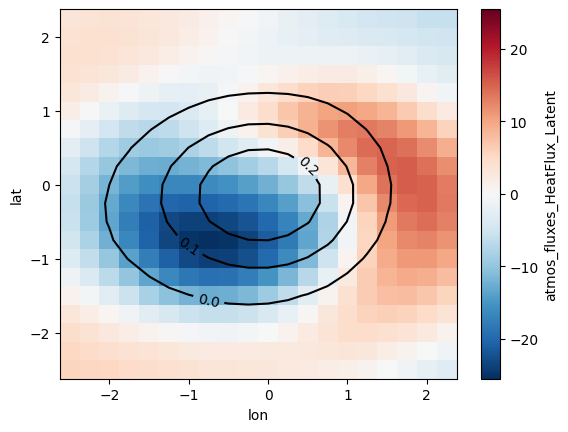

In [14]:
varname='atmos_fluxes_HeatFlux_Latent'
FIELDcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings '+varname+' for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            FIELD=dsvar[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                FIELDcomp.append(FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dsvar)
            del(FIELD)
            del(ARidx)
            del(a)
            # del(c)
            del(date)
            
        
# res=0.25
# npts=int(dlon/res) #number of points from centre
for ii in range(len(FIELDcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)          
            

Grab Agulhas rings to for YYYY=2020
Skip mth=1
Grab Agulhas rings to for YYYY=2021
Grab Agulhas rings to for YYYY=2022
Grab Agulhas rings to for YYYY=2023
Grab Agulhas rings to for YYYY=2024
Grab Agulhas rings to for YYYY=2025
Grab Agulhas rings to for YYYY=2026
Grab Agulhas rings to for YYYY=2027
Grab Agulhas rings to for YYYY=2028
Grab Agulhas rings to for YYYY=2029
Grab Agulhas rings to for YYYY=2030
Grab Agulhas rings to for YYYY=2031
Grab Agulhas rings to for YYYY=2032
Grab Agulhas rings to for YYYY=2033
Grab Agulhas rings to for YYYY=2034
Grab Agulhas rings to for YYYY=2035
Grab Agulhas rings to for YYYY=2036
Grab Agulhas rings to for YYYY=2037
Grab Agulhas rings to for YYYY=2038
Grab Agulhas rings to for YYYY=2039
Grab Agulhas rings to for YYYY=2040
Grab Agulhas rings to for YYYY=2041
Grab Agulhas rings to for YYYY=2042
Grab Agulhas rings to for YYYY=2043
Grab Agulhas rings to for YYYY=2044
Grab Agulhas rings to for YYYY=2045
Grab Agulhas rings to for YYYY=2046
Grab Agulhas ring

<a list of 3 text.Text objects>

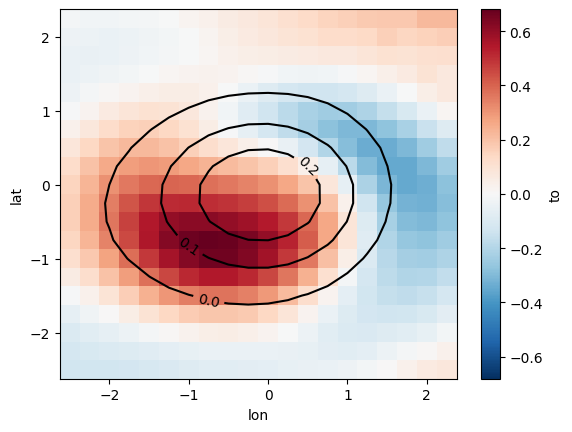

In [13]:
varname='to'
zidx=1
FIELDcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings '+varname+' for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            FIELD=dsvar[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                FIELDcomp.append(FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dsvar)
            del(FIELD)
            del(ARidx)
            del(a)
            # del(c)
            del(date)
            
        
# res=0.25
# npts=int(dlon/res) #number of points from centre
for ii in range(len(FIELDcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)          
            

Grab Agulhas rings atmos_fluxes_FrshFlux_Precipitation for YYYY=2020
Skip mth=1
Grab Agulhas rings atmos_fluxes_FrshFlux_Precipitation for YYYY=2021
Grab Agulhas rings atmos_fluxes_FrshFlux_Precipitation for YYYY=2022
Grab Agulhas rings atmos_fluxes_FrshFlux_Precipitation for YYYY=2023
Grab Agulhas rings atmos_fluxes_FrshFlux_Precipitation for YYYY=2024
Grab Agulhas rings atmos_fluxes_FrshFlux_Precipitation for YYYY=2025
Grab Agulhas rings atmos_fluxes_FrshFlux_Precipitation for YYYY=2026
Grab Agulhas rings atmos_fluxes_FrshFlux_Precipitation for YYYY=2027
Grab Agulhas rings atmos_fluxes_FrshFlux_Precipitation for YYYY=2028
Grab Agulhas rings atmos_fluxes_FrshFlux_Precipitation for YYYY=2029
Grab Agulhas rings atmos_fluxes_FrshFlux_Precipitation for YYYY=2030
Grab Agulhas rings atmos_fluxes_FrshFlux_Precipitation for YYYY=2031
Grab Agulhas rings atmos_fluxes_FrshFlux_Precipitation for YYYY=2032
Grab Agulhas rings atmos_fluxes_FrshFlux_Precipitation for YYYY=2033
Grab Agulhas rings atmo

<a list of 3 text.Text objects>

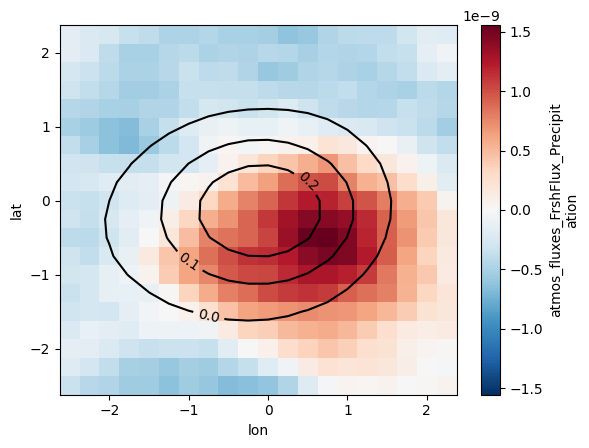

In [15]:
varname='atmos_fluxes_FrshFlux_Precipitation'
FIELDcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings '+varname+' for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            FIELD=dsvar[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                FIELDcomp.append(FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dsvar)
            del(FIELD)
            del(ARidx)
            del(a)
            # del(c)
            del(date)
            
        
# res=0.25
# npts=int(dlon/res) #number of points from centre
for ii in range(len(FIELDcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)          
            

Grab Agulhas rings mlotst for YYYY=2020
Skip mth=1
Grab Agulhas rings mlotst for YYYY=2021
Grab Agulhas rings mlotst for YYYY=2022
Grab Agulhas rings mlotst for YYYY=2023
Grab Agulhas rings mlotst for YYYY=2024
Grab Agulhas rings mlotst for YYYY=2025
Grab Agulhas rings mlotst for YYYY=2026
Grab Agulhas rings mlotst for YYYY=2027
Grab Agulhas rings mlotst for YYYY=2028
Grab Agulhas rings mlotst for YYYY=2029
Grab Agulhas rings mlotst for YYYY=2030
Grab Agulhas rings mlotst for YYYY=2031
Grab Agulhas rings mlotst for YYYY=2032
Grab Agulhas rings mlotst for YYYY=2033
Grab Agulhas rings mlotst for YYYY=2034
Grab Agulhas rings mlotst for YYYY=2035
Grab Agulhas rings mlotst for YYYY=2036
Grab Agulhas rings mlotst for YYYY=2037
Grab Agulhas rings mlotst for YYYY=2038
Grab Agulhas rings mlotst for YYYY=2039
Grab Agulhas rings mlotst for YYYY=2040
Grab Agulhas rings mlotst for YYYY=2041
Grab Agulhas rings mlotst for YYYY=2042
Grab Agulhas rings mlotst for YYYY=2043
Grab Agulhas rings mlotst for

<a list of 3 text.Text objects>

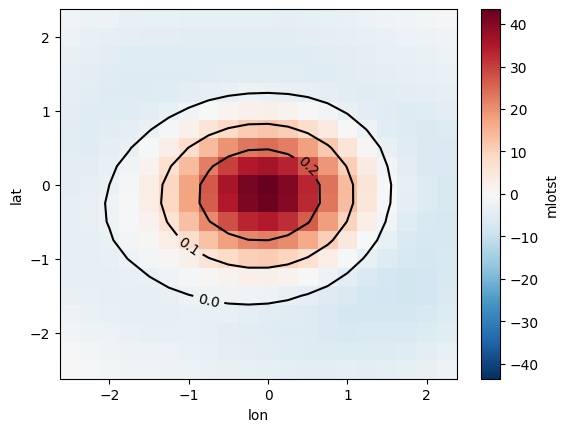

In [16]:
varname='mlotst'
FIELDcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings '+varname+' for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            FIELD=dsvar[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                FIELDcomp.append(FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dsvar)
            del(FIELD)
            del(ARidx)
            del(a)
            # del(c)
            del(date)
            
        
# res=0.25
# npts=int(dlon/res) #number of points from centre
for ii in range(len(FIELDcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)          
            

Grab Agulhas rings HCdiv for YYYY=2020
Skip mth=1
Grab Agulhas rings HCdiv for YYYY=2021
Grab Agulhas rings HCdiv for YYYY=2022
Grab Agulhas rings HCdiv for YYYY=2023
Grab Agulhas rings HCdiv for YYYY=2024
Grab Agulhas rings HCdiv for YYYY=2025
Grab Agulhas rings HCdiv for YYYY=2026
Grab Agulhas rings HCdiv for YYYY=2027
Grab Agulhas rings HCdiv for YYYY=2028
Grab Agulhas rings HCdiv for YYYY=2029
Grab Agulhas rings HCdiv for YYYY=2030
Grab Agulhas rings HCdiv for YYYY=2031
Grab Agulhas rings HCdiv for YYYY=2032
Grab Agulhas rings HCdiv for YYYY=2033
Grab Agulhas rings HCdiv for YYYY=2034
Grab Agulhas rings HCdiv for YYYY=2035
Grab Agulhas rings HCdiv for YYYY=2036
Grab Agulhas rings HCdiv for YYYY=2037
Grab Agulhas rings HCdiv for YYYY=2038
Grab Agulhas rings HCdiv for YYYY=2039
Grab Agulhas rings HCdiv for YYYY=2040
Grab Agulhas rings HCdiv for YYYY=2041
Grab Agulhas rings HCdiv for YYYY=2042
Grab Agulhas rings HCdiv for YYYY=2043
Grab Agulhas rings HCdiv for YYYY=2044
Grab Agulhas r

<a list of 3 text.Text objects>

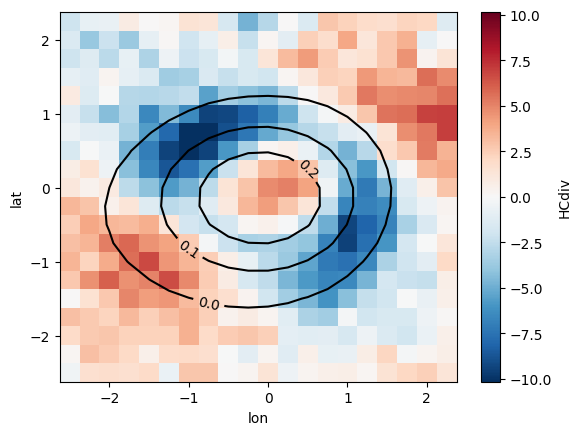

In [6]:
varname='HCdiv'
zidx=1
FIELDcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings '+varname+' for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            # dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25.nc')
            FIELD=dsvar[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                FIELDcomp.append(FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dsvar)
            del(FIELD)
            del(ARidx)
            del(a)
            # del(c)
            del(date)
            
        
# res=0.25
# npts=int(dlon/res) #number of points from centre
for ii in range(len(FIELDcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)          
            

Grab Agulhas rings HCdiv for YYYY=2020
Skip mth=1
Grab Agulhas rings HCdiv for YYYY=2021
Grab Agulhas rings HCdiv for YYYY=2022
Grab Agulhas rings HCdiv for YYYY=2023
Grab Agulhas rings HCdiv for YYYY=2024
Grab Agulhas rings HCdiv for YYYY=2025
Grab Agulhas rings HCdiv for YYYY=2026
Grab Agulhas rings HCdiv for YYYY=2027
Grab Agulhas rings HCdiv for YYYY=2028
Grab Agulhas rings HCdiv for YYYY=2029
Grab Agulhas rings HCdiv for YYYY=2030
Grab Agulhas rings HCdiv for YYYY=2031
Grab Agulhas rings HCdiv for YYYY=2032
Grab Agulhas rings HCdiv for YYYY=2033
Grab Agulhas rings HCdiv for YYYY=2034
Grab Agulhas rings HCdiv for YYYY=2035
Grab Agulhas rings HCdiv for YYYY=2036
Grab Agulhas rings HCdiv for YYYY=2037
Grab Agulhas rings HCdiv for YYYY=2038
Grab Agulhas rings HCdiv for YYYY=2039
Grab Agulhas rings HCdiv for YYYY=2040
Grab Agulhas rings HCdiv for YYYY=2041
Grab Agulhas rings HCdiv for YYYY=2042
Grab Agulhas rings HCdiv for YYYY=2043
Grab Agulhas rings HCdiv for YYYY=2044
Grab Agulhas r

<a list of 3 text.Text objects>

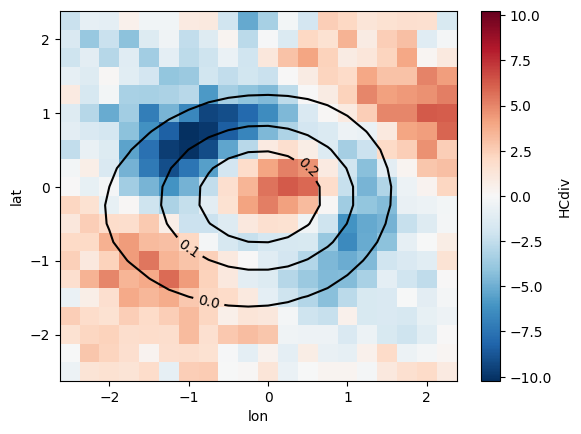

In [7]:
varname='HCdiv'
zidx=2
FIELDcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings '+varname+' for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            # dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25.nc')
            FIELD=dsvar[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                FIELDcomp.append(FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dsvar)
            del(FIELD)
            del(ARidx)
            del(a)
            # del(c)
            del(date)
            
        
# res=0.25
# npts=int(dlon/res) #number of points from centre
for ii in range(len(FIELDcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)          
            

Grab Agulhas rings HCdiv for YYYY=2020
Skip mth=1
Grab Agulhas rings HCdiv for YYYY=2021
Grab Agulhas rings HCdiv for YYYY=2022
Grab Agulhas rings HCdiv for YYYY=2023
Grab Agulhas rings HCdiv for YYYY=2024
Grab Agulhas rings HCdiv for YYYY=2025
Grab Agulhas rings HCdiv for YYYY=2026
Grab Agulhas rings HCdiv for YYYY=2027
Grab Agulhas rings HCdiv for YYYY=2028
Grab Agulhas rings HCdiv for YYYY=2029
Grab Agulhas rings HCdiv for YYYY=2030
Grab Agulhas rings HCdiv for YYYY=2031
Grab Agulhas rings HCdiv for YYYY=2032
Grab Agulhas rings HCdiv for YYYY=2033
Grab Agulhas rings HCdiv for YYYY=2034
Grab Agulhas rings HCdiv for YYYY=2035
Grab Agulhas rings HCdiv for YYYY=2036
Grab Agulhas rings HCdiv for YYYY=2037
Grab Agulhas rings HCdiv for YYYY=2038
Grab Agulhas rings HCdiv for YYYY=2039
Grab Agulhas rings HCdiv for YYYY=2040
Grab Agulhas rings HCdiv for YYYY=2041
Grab Agulhas rings HCdiv for YYYY=2042
Grab Agulhas rings HCdiv for YYYY=2043
Grab Agulhas rings HCdiv for YYYY=2044
Grab Agulhas r

<a list of 3 text.Text objects>

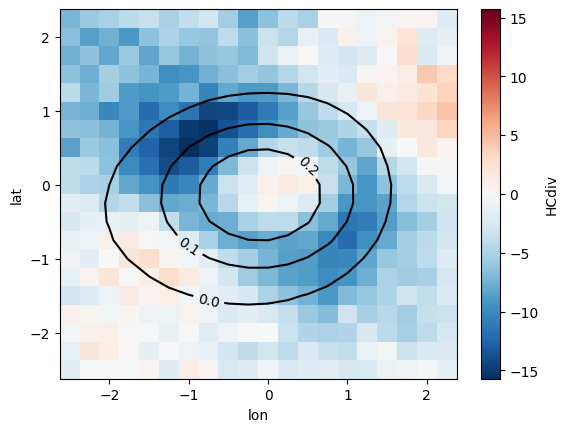

In [32]:
varname='HCdiv'
zidx=1
FIELDcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings '+varname+' for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            # dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25.nc')
            FIELD=dsvar[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                FIELDcomp.append(FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dsvar)
            del(FIELD)
            del(ARidx)
            del(a)
            # del(c)
            del(date)
            
        
# res=0.25
# npts=int(dlon/res) #number of points from centre
for ii in range(len(FIELDcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').mean(dim="time").plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)          
            

In [1]:
# from matplotlib import cm
# newFIELDcomp=xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').mean(dim="time")

# fig=plt.figure(1, figsize=(6,6),dpi=100)
# plt.pcolor(newFIELDcomp.lon,newFIELDcomp.lat,newFIELDcomp,vmin=-30,vmax=30,cmap=cm.RdBu_r)
# plt.colorbar()
# plt.ylabel('lat')
# plt.xlabel('lon')
# plt.title('Composite of '+varname+' at level '+str(zidx))
# #plt.show()

Grab Agulhas rings taudiv for YYYY=2020
Skip mth=1
Grab Agulhas rings taudiv for YYYY=2021
Grab Agulhas rings taudiv for YYYY=2022
Grab Agulhas rings taudiv for YYYY=2023
Grab Agulhas rings taudiv for YYYY=2024
Grab Agulhas rings taudiv for YYYY=2025
Grab Agulhas rings taudiv for YYYY=2026
Grab Agulhas rings taudiv for YYYY=2027
Grab Agulhas rings taudiv for YYYY=2028
Grab Agulhas rings taudiv for YYYY=2029
Grab Agulhas rings taudiv for YYYY=2030
Grab Agulhas rings taudiv for YYYY=2031
Grab Agulhas rings taudiv for YYYY=2032
Grab Agulhas rings taudiv for YYYY=2033
Grab Agulhas rings taudiv for YYYY=2034
Grab Agulhas rings taudiv for YYYY=2035
Grab Agulhas rings taudiv for YYYY=2036
Grab Agulhas rings taudiv for YYYY=2037
Grab Agulhas rings taudiv for YYYY=2038
Grab Agulhas rings taudiv for YYYY=2039
Grab Agulhas rings taudiv for YYYY=2040
Grab Agulhas rings taudiv for YYYY=2041
Grab Agulhas rings taudiv for YYYY=2042
Grab Agulhas rings taudiv for YYYY=2043
Grab Agulhas rings taudiv for

<a list of 3 text.Text objects>

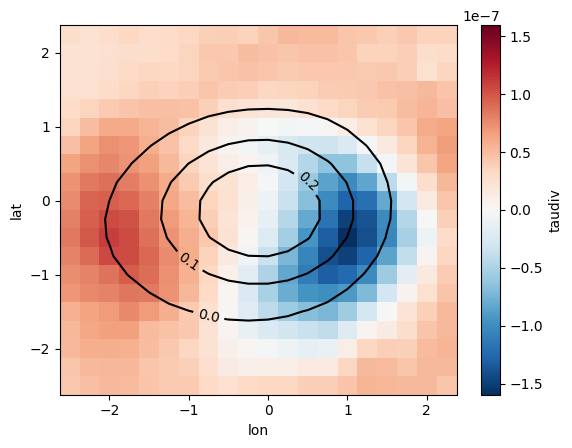

In [33]:
varname='taudiv'
FIELDcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings '+varname+' for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            # dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25.nc')
            FIELD=dsvar[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                FIELDcomp.append(FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dsvar)
            del(FIELD)
            del(ARidx)
            del(a)
            # del(c)
            del(date)
            
        
# res=0.25
# npts=int(dlon/res) #number of points from centre
for ii in range(len(FIELDcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').mean(dim="time").plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)          
            

Grab Agulhas rings taudiv for YYYY=2020
Skip mth=1
Grab Agulhas rings taudiv for YYYY=2021
Grab Agulhas rings taudiv for YYYY=2022
Grab Agulhas rings taudiv for YYYY=2023
Grab Agulhas rings taudiv for YYYY=2024
Grab Agulhas rings taudiv for YYYY=2025
Grab Agulhas rings taudiv for YYYY=2026
Grab Agulhas rings taudiv for YYYY=2027
Grab Agulhas rings taudiv for YYYY=2028
Grab Agulhas rings taudiv for YYYY=2029
Grab Agulhas rings taudiv for YYYY=2030
Grab Agulhas rings taudiv for YYYY=2031
Grab Agulhas rings taudiv for YYYY=2032
Grab Agulhas rings taudiv for YYYY=2033
Grab Agulhas rings taudiv for YYYY=2034
Grab Agulhas rings taudiv for YYYY=2035
Grab Agulhas rings taudiv for YYYY=2036
Grab Agulhas rings taudiv for YYYY=2037
Grab Agulhas rings taudiv for YYYY=2038
Grab Agulhas rings taudiv for YYYY=2039
Grab Agulhas rings taudiv for YYYY=2040
Grab Agulhas rings taudiv for YYYY=2041
Grab Agulhas rings taudiv for YYYY=2042
Grab Agulhas rings taudiv for YYYY=2043
Grab Agulhas rings taudiv for

<a list of 3 text.Text objects>

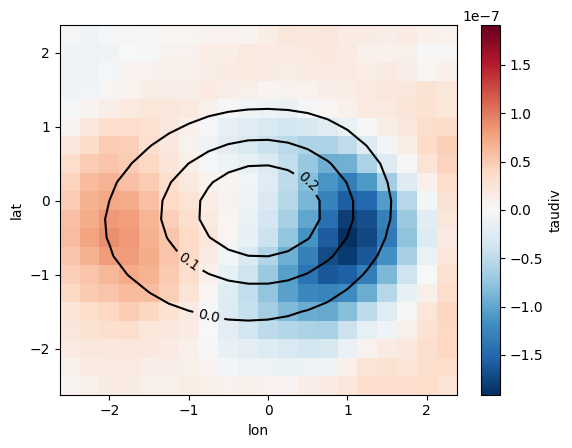

In [34]:
varname='taudiv'
FIELDcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings '+varname+' for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            # dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25.nc')
            FIELD=dsvar[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                FIELDcomp.append(FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dsvar)
            del(FIELD)
            del(ARidx)
            del(a)
            # del(c)
            del(date)
            
        
# res=0.25
# npts=int(dlon/res) #number of points from centre
for ii in range(len(FIELDcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)        
            

Grab Agulhas rings downSSTgrad for YYYY=2020
Skip mth=1
Grab Agulhas rings downSSTgrad for YYYY=2021
Grab Agulhas rings downSSTgrad for YYYY=2022
Grab Agulhas rings downSSTgrad for YYYY=2023
Grab Agulhas rings downSSTgrad for YYYY=2024
Grab Agulhas rings downSSTgrad for YYYY=2025
Grab Agulhas rings downSSTgrad for YYYY=2026
Grab Agulhas rings downSSTgrad for YYYY=2027
Grab Agulhas rings downSSTgrad for YYYY=2028
Grab Agulhas rings downSSTgrad for YYYY=2029
Grab Agulhas rings downSSTgrad for YYYY=2030
Grab Agulhas rings downSSTgrad for YYYY=2031
Grab Agulhas rings downSSTgrad for YYYY=2032
Grab Agulhas rings downSSTgrad for YYYY=2033
Grab Agulhas rings downSSTgrad for YYYY=2034
Grab Agulhas rings downSSTgrad for YYYY=2035
Grab Agulhas rings downSSTgrad for YYYY=2036
Grab Agulhas rings downSSTgrad for YYYY=2037
Grab Agulhas rings downSSTgrad for YYYY=2038
Grab Agulhas rings downSSTgrad for YYYY=2039
Grab Agulhas rings downSSTgrad for YYYY=2040
Grab Agulhas rings downSSTgrad for YYYY=2041

<a list of 3 text.Text objects>

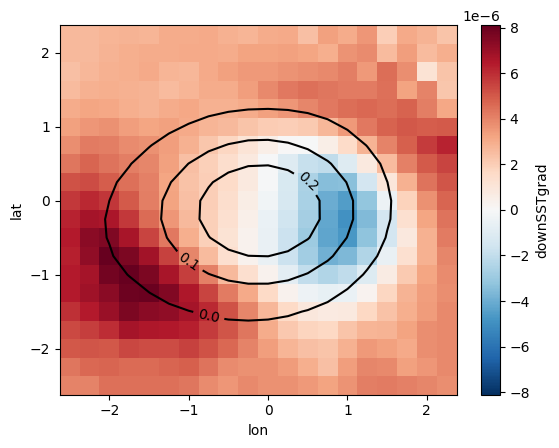

In [8]:
varname='downSSTgrad'
FIELDcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings '+varname+' for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            # dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25.nc')
            FIELD=dsvar[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                FIELDcomp.append(FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dsvar)
            del(FIELD)
            del(ARidx)
            del(a)
            # del(c)
            del(date)
            
        
# res=0.25
# npts=int(dlon/res) #number of points from centre
for ii in range(len(FIELDcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').mean(dim="time").plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)          
            

Grab Agulhas rings downSSTgrad for YYYY=2020
Skip mth=1
Grab Agulhas rings downSSTgrad for YYYY=2021
Grab Agulhas rings downSSTgrad for YYYY=2022
Grab Agulhas rings downSSTgrad for YYYY=2023
Grab Agulhas rings downSSTgrad for YYYY=2024
Grab Agulhas rings downSSTgrad for YYYY=2025
Grab Agulhas rings downSSTgrad for YYYY=2026
Grab Agulhas rings downSSTgrad for YYYY=2027
Grab Agulhas rings downSSTgrad for YYYY=2028
Grab Agulhas rings downSSTgrad for YYYY=2029
Grab Agulhas rings downSSTgrad for YYYY=2030
Grab Agulhas rings downSSTgrad for YYYY=2031
Grab Agulhas rings downSSTgrad for YYYY=2032
Grab Agulhas rings downSSTgrad for YYYY=2033
Grab Agulhas rings downSSTgrad for YYYY=2034
Grab Agulhas rings downSSTgrad for YYYY=2035
Grab Agulhas rings downSSTgrad for YYYY=2036
Grab Agulhas rings downSSTgrad for YYYY=2037
Grab Agulhas rings downSSTgrad for YYYY=2038
Grab Agulhas rings downSSTgrad for YYYY=2039
Grab Agulhas rings downSSTgrad for YYYY=2040
Grab Agulhas rings downSSTgrad for YYYY=2041

<a list of 3 text.Text objects>

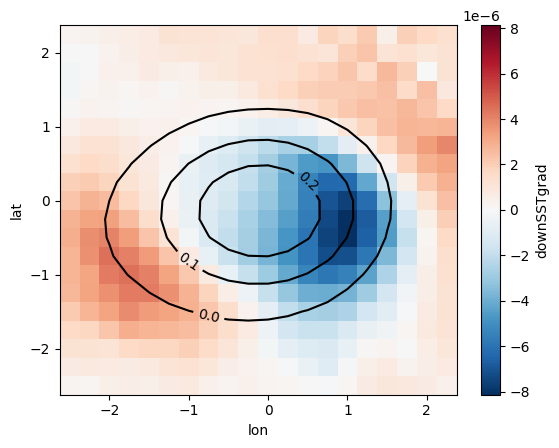

In [9]:
varname='downSSTgrad'
FIELDcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings '+varname+' for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            # dsvar=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25.nc')
            FIELD=dsvar[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                FIELDcomp.append(FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dsvar)
            del(FIELD)
            del(ARidx)
            del(a)
            # del(c)
            del(date)
            
        
# res=0.25
# npts=int(dlon/res) #number of points from centre
for ii in range(len(FIELDcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)        
            

Grab Agulhas rings Tfluxdiv for YYYY=2020
Skip mth=1
Grab Agulhas rings Tfluxdiv for YYYY=2021
Grab Agulhas rings Tfluxdiv for YYYY=2022
Grab Agulhas rings Tfluxdiv for YYYY=2023
Grab Agulhas rings Tfluxdiv for YYYY=2024
Grab Agulhas rings Tfluxdiv for YYYY=2025
Grab Agulhas rings Tfluxdiv for YYYY=2026
Grab Agulhas rings Tfluxdiv for YYYY=2027
Grab Agulhas rings Tfluxdiv for YYYY=2028
Grab Agulhas rings Tfluxdiv for YYYY=2029
Grab Agulhas rings Tfluxdiv for YYYY=2030
Grab Agulhas rings Tfluxdiv for YYYY=2031
Grab Agulhas rings Tfluxdiv for YYYY=2032
Grab Agulhas rings Tfluxdiv for YYYY=2033
Grab Agulhas rings Tfluxdiv for YYYY=2034
Grab Agulhas rings Tfluxdiv for YYYY=2035
Grab Agulhas rings Tfluxdiv for YYYY=2036
Grab Agulhas rings Tfluxdiv for YYYY=2037
Grab Agulhas rings Tfluxdiv for YYYY=2038
Grab Agulhas rings Tfluxdiv for YYYY=2039
Grab Agulhas rings Tfluxdiv for YYYY=2040
Grab Agulhas rings Tfluxdiv for YYYY=2041
Grab Agulhas rings Tfluxdiv for YYYY=2042
Grab Agulhas rings Tflu

<a list of 3 text.Text objects>

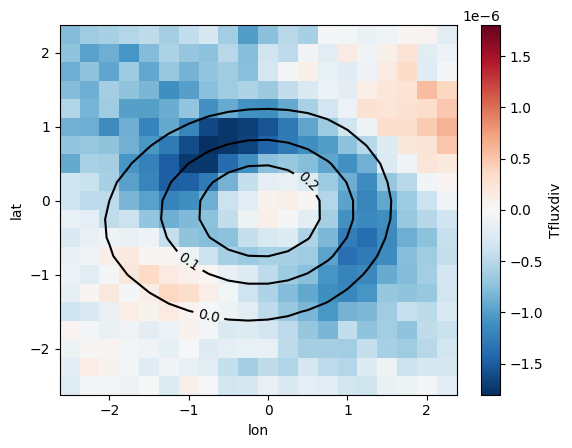

In [5]:
#Full field for total Tflux divergence
zidx=1
varname='Tfluxdiv'
FIELDcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings '+varname+' for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            # dsvar=xr.open_dataset(outdir+varname+'/'+expid+'_tot'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            dsvar=xr.open_dataset(outdir+varname+'/'+expid+'_tot'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25.nc')
            FIELD=dsvar[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                FIELDcomp.append(FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dsvar)
            del(FIELD)
            del(ARidx)
            del(a)
            # del(c)
            del(date)
            
        
# res=0.25
# npts=int(dlon/res) #number of points from centre
for ii in range(len(FIELDcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').mean(dim="time").plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)          
            

Grab Agulhas rings Tfluxdiv for YYYY=2020
Skip mth=1
Grab Agulhas rings Tfluxdiv for YYYY=2021
Grab Agulhas rings Tfluxdiv for YYYY=2022
Grab Agulhas rings Tfluxdiv for YYYY=2023
Grab Agulhas rings Tfluxdiv for YYYY=2024
Grab Agulhas rings Tfluxdiv for YYYY=2025
Grab Agulhas rings Tfluxdiv for YYYY=2026
Grab Agulhas rings Tfluxdiv for YYYY=2027
Grab Agulhas rings Tfluxdiv for YYYY=2028
Grab Agulhas rings Tfluxdiv for YYYY=2029
Grab Agulhas rings Tfluxdiv for YYYY=2030
Grab Agulhas rings Tfluxdiv for YYYY=2031
Grab Agulhas rings Tfluxdiv for YYYY=2032
Grab Agulhas rings Tfluxdiv for YYYY=2033
Grab Agulhas rings Tfluxdiv for YYYY=2034
Grab Agulhas rings Tfluxdiv for YYYY=2035
Grab Agulhas rings Tfluxdiv for YYYY=2036
Grab Agulhas rings Tfluxdiv for YYYY=2037
Grab Agulhas rings Tfluxdiv for YYYY=2038
Grab Agulhas rings Tfluxdiv for YYYY=2039
Grab Agulhas rings Tfluxdiv for YYYY=2040
Grab Agulhas rings Tfluxdiv for YYYY=2041
Grab Agulhas rings Tfluxdiv for YYYY=2042
Grab Agulhas rings Tflu

<a list of 3 text.Text objects>

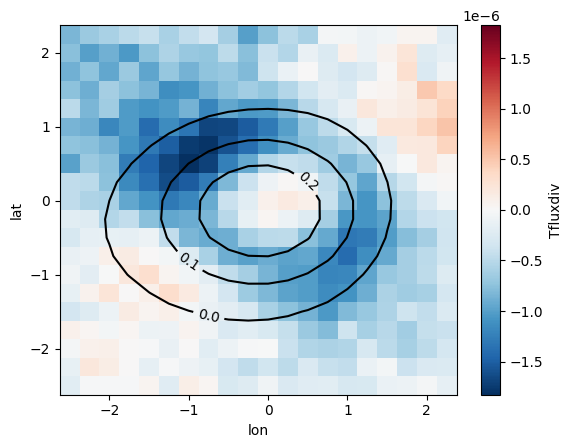

In [7]:
#Full field for mean Tflux divergence
zidx=1
varname='Tfluxdiv'
FIELDcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings '+varname+' for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            # dsvar=xr.open_dataset(outdir+varname+'/'+expid+'_mean'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            dsvar=xr.open_dataset(outdir+varname+'/'+expid+'_mean'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25.nc')
            FIELD=dsvar[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                FIELDcomp.append(FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dsvar)
            del(FIELD)
            del(ARidx)
            del(a)
            # del(c)
            del(date)
            
        
# res=0.25
# npts=int(dlon/res) #number of points from centre
for ii in range(len(FIELDcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').mean(dim="time").plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)          
            

Grab Agulhas rings Tfluxdiv for YYYY=2020
Skip mth=1
Grab Agulhas rings Tfluxdiv for YYYY=2021
Grab Agulhas rings Tfluxdiv for YYYY=2022
Grab Agulhas rings Tfluxdiv for YYYY=2023
Grab Agulhas rings Tfluxdiv for YYYY=2024
Grab Agulhas rings Tfluxdiv for YYYY=2025
Grab Agulhas rings Tfluxdiv for YYYY=2026
Grab Agulhas rings Tfluxdiv for YYYY=2027
Grab Agulhas rings Tfluxdiv for YYYY=2028
Grab Agulhas rings Tfluxdiv for YYYY=2029
Grab Agulhas rings Tfluxdiv for YYYY=2030
Grab Agulhas rings Tfluxdiv for YYYY=2031
Grab Agulhas rings Tfluxdiv for YYYY=2032
Grab Agulhas rings Tfluxdiv for YYYY=2033
Grab Agulhas rings Tfluxdiv for YYYY=2034
Grab Agulhas rings Tfluxdiv for YYYY=2035
Grab Agulhas rings Tfluxdiv for YYYY=2036
Grab Agulhas rings Tfluxdiv for YYYY=2037
Grab Agulhas rings Tfluxdiv for YYYY=2038
Grab Agulhas rings Tfluxdiv for YYYY=2039
Grab Agulhas rings Tfluxdiv for YYYY=2040
Grab Agulhas rings Tfluxdiv for YYYY=2041
Grab Agulhas rings Tfluxdiv for YYYY=2042
Grab Agulhas rings Tflu

<a list of 3 text.Text objects>

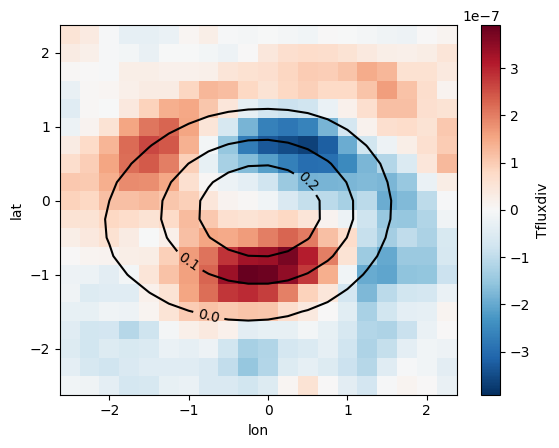

In [8]:
#Full field for eddy Tflux divergence
zidx=1
varname='Tfluxdiv'
FIELDcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings '+varname+' for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            # dsvar=xr.open_dataset(outdir+varname+'/'+expid+'_eddy'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            dsvar=xr.open_dataset(outdir+varname+'/'+expid+'_eddy'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25.nc')
            FIELD=dsvar[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                FIELDcomp.append(FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dsvar)
            del(FIELD)
            del(ARidx)
            del(a)
            # del(c)
            del(date)
            
        
# res=0.25
# npts=int(dlon/res) #number of points from centre
for ii in range(len(FIELDcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').mean(dim="time").plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)          
            

In [6]:
#high-pass field for total Tflux divergence
zidx=1
varname='Tfluxdiv'
FIELDcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings '+varname+' for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            dsvar=xr.open_dataset(outdir+varname+'/'+expid+'_tot'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            # dsvar=xr.open_dataset(outdir+varname+'/'+expid+'_tot'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25.nc')
            FIELD=dsvar[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                FIELDcomp.append(FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dsvar)
            del(FIELD)
            del(ARidx)
            del(a)
            # del(c)
            del(date)
            
        
# res=0.25
# npts=int(dlon/res) #number of points from centre
for ii in range(len(FIELDcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').mean(dim="time").plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)          
            

In [7]:
#high-pass field for mean Tflux divergence
zidx=1
varname='Tfluxdiv'
FIELDcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings '+varname+' for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            dsvar=xr.open_dataset(outdir+varname+'/'+expid+'_mean'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            # dsvar=xr.open_dataset(outdir+varname+'/'+expid+'_mean'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25.nc')
            FIELD=dsvar[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                FIELDcomp.append(FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dsvar)
            del(FIELD)
            del(ARidx)
            del(a)
            # del(c)
            del(date)
            
        
# res=0.25
# npts=int(dlon/res) #number of points from centre
for ii in range(len(FIELDcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').mean(dim="time").plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)          
            

In [ ]:
#high-pass field for eddy Tflux divergence
zidx=1
varname='Tfluxdiv'
FIELDcomp=[]
for yr in range(2020,2050):
    print('Grab Agulhas rings '+varname+' for YYYY='+str(yr))
    for mth in range(1,13):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+'zos/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ### ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            dsvar=xr.open_dataset(outdir+varname+'/'+expid+'_eddy'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            # dsvar=xr.open_dataset(outdir+varname+'/'+expid+'_eddy'+varname+'_'+str(zidx)+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25.nc')
            FIELD=dsvar[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                FIELDcomp.append(FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dsvar)
            del(FIELD)
            del(ARidx)
            del(a)
            # del(c)
            del(date)
            
        
# res=0.25
# npts=int(dlon/res) #number of points from centre
for ii in range(len(FIELDcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy').mean(dim="time").plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)          
            

Grab Agulhas rings for YYYY=2020
Skip mth=1
Grab Agulhas rings for YYYY=2021
Grab Agulhas rings for YYYY=2022
Grab Agulhas rings for YYYY=2023
Grab Agulhas rings for YYYY=2024
Grab Agulhas rings for YYYY=2025
Grab Agulhas rings for YYYY=2026
Grab Agulhas rings for YYYY=2027
Grab Agulhas rings for YYYY=2028
Grab Agulhas rings for YYYY=2029
Grab Agulhas rings for YYYY=2030
Grab Agulhas rings for YYYY=2031
Grab Agulhas rings for YYYY=2032
Grab Agulhas rings for YYYY=2033
Grab Agulhas rings for YYYY=2034
Grab Agulhas rings for YYYY=2035
Grab Agulhas rings for YYYY=2036
Grab Agulhas rings for YYYY=2037
Grab Agulhas rings for YYYY=2038
Grab Agulhas rings for YYYY=2039
Grab Agulhas rings for YYYY=2040
Grab Agulhas rings for YYYY=2041
Grab Agulhas rings for YYYY=2042
Grab Agulhas rings for YYYY=2043
Grab Agulhas rings for YYYY=2044
Grab Agulhas rings for YYYY=2045
Grab Agulhas rings for YYYY=2046
Grab Agulhas rings for YYYY=2047
Grab Agulhas rings for YYYY=2048
Grab Agulhas rings for YYYY=2049

<a list of 3 text.Text objects>

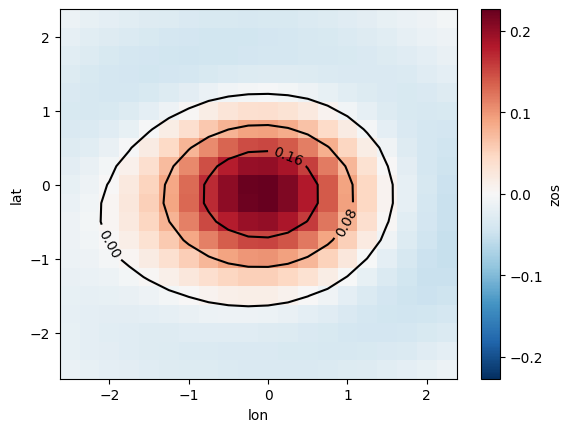

In [37]:
#Get Agulhas rings and composite
#Try crossing the meridian

# from matplotlib import pyplot as plt
# from matplotlib.path import Path
# from numpy import ones
# from datetime import datetime
# import numpy as np
# import warnings
# import xarray as xr

# from py_eddy_tracker import data
# from py_eddy_tracker.dataset.grid import RegularGridDataset, GridDataset
# from py_eddy_tracker.observations.observation import EddiesObservations
# from py_eddy_tracker.poly import create_vertice


expid='ngc2013'
varname='zos'
fq='mm'
outdir='/work/mh0287/m300466/topaz/'+expid+'/'
wavelength = 700  #choice of spatial cutoff for high pass filter in km

dlon=2.5
dlat=2.5

SSHcomp=[]
for yr in range(2020,2050):
# for yr in range(2049,2050):
    print('Grab Agulhas rings for YYYY='+str(yr))
    for mth in range(1,13):
    # for mth in range(2,3):
        if (yr==2020) & (mth==1):
            print('Skip mth=1')
        else:
            date = datetime(yr, mth, 1)
            # print('Grab Agulhas rings for YYYYMM='+date.strftime('%Y%m'))
            warnings.filterwarnings("ignore", message="File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'")
            a = EddiesObservations.load_file(outdir+varname+'/'+fq+'/'+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            # c = EddiesObservations.load_file(outdir+varname+'/'+fq+'/'+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m')+".nc")
            #Get eddy ID# for region around Agulhas leakage
            ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<25)) ) 
            ### If composite crosses dateline, this causes issues.
            # ARidx = np.argwhere((a.lat<=-20) & (a.lat>=-45) & (a.lon>2.5) & (a.lon<25)) 
            ##Now we make composites that are 2deg from eddy centre based on filtered fields
            dssh=xr.open_dataset(outdir+varname+'/'+fq+'/'+expid+'_'+varname+'_'+fq+'_'+date.strftime('%Y%m')+'_MR25_hp'+str(wavelength)+'.nc')
            SSH=dssh[varname]
            for ii in range(len(ARidx)):
                # print('Eddy ID: ',str(ARidx[ii][0]))
                # print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
                # print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
                lonmin=a.lon[ARidx][ii][0]-dlon
                lonmax=a.lon[ARidx][ii][0]+dlon
                latmin=a.lat[ARidx][ii][0]-dlat
                latmax=a.lat[ARidx][ii][0]+dlat
                # print(str(lonmin)+', '+str(lonmax))
                if (lonmin < 0):
                    SSHcomp.append(xr.concat([SSH.sel(lon=slice(lonmin+360,360),lat=slice(latmin,latmax)),SSH.sel(lon=slice(0,lonmax),lat=slice(latmin,latmax))],dim='lon'))
                elif (lonmax > 360):
                    SSHcomp.append(xr.concat([SSH.sel(lon=slice(lonmin,360),lat=slice(latmin,latmax)),SSH.sel(lon=slice(0,lonmax-360),lat=slice(latmin,latmax))],dim='lon'))
                else:
                    SSHcomp.append(SSH.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))
            del(dssh)
            del(SSH)
            del(ARidx)
            del(a)
            # del(c)
            del(date)

        
res=0.25
npts=int(dlon/res) #number of points from centre
for ii in range(len(SSHcomp)):
    # print('Centering eddy #'+str(ii)+' out of '+str(len(SSHcomp)-1))
    SSHcomp[ii]=SSHcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)


fig, ax = plt.subplots()
xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').squeeze().plot.contour(cmap='k', ax=ax)
ax.clabel(CS)